In [108]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
# %matplotlib widget

%run ./scripts/util_func.py

In [109]:
# import data to dataframe

data = pd.read_csv("/home/dominic/Documents/publications/sensors2021/offline_model_training/powertrain_dynamics_IPEM/data/data_imu_parking.csv") 

array_start_cut = 2

data = data.iloc[array_start_cut:]

print(data)

       Unnamed: 0      ros_time  wheel_meas_index  cmd_right_vel  \
2               2  1.604599e+18               0.0            0.0   
3               3  1.604599e+18               0.0            0.0   
4               4  1.604599e+18               0.0            0.0   
5               5  1.604599e+18               0.0            0.0   
6               6  1.604599e+18               0.0            0.0   
...           ...           ...               ...            ...   
40116       40116  1.604599e+18             360.0            0.0   
40117       40117  1.604599e+18             360.0            0.0   
40118       40118  1.604599e+18             360.0            0.0   
40119       40119  1.604599e+18             360.0            0.0   
40120       40120  1.604599e+18             360.0            0.0   

       meas_right_vel  js_right_vel   imu_vel  
2                 0.0           0.0  0.018279  
3                 0.0           0.0  0.018279  
4                 0.0           0.0 -0.

In [110]:
# convert dataframe to numpy array

array = data.to_numpy()
array =np.delete(array,[0],axis=0)

time_arr = array[:,1]
time_arr = (time_arr - time_arr[0]) * 10**(-9)
meas_index_arr = array[:,2]

left_vel_cmd_arr = array[:,3]
left_vel_meas_arr = array[:,4]
left_vel_js_arr = array[:,5]
imu_arr = array[:,6]

print(time_arr)


[0.00000000e+00 1.00917760e-02 2.01671680e-02 ... 4.01155072e+02
 4.01165168e+02 4.01175220e+02]


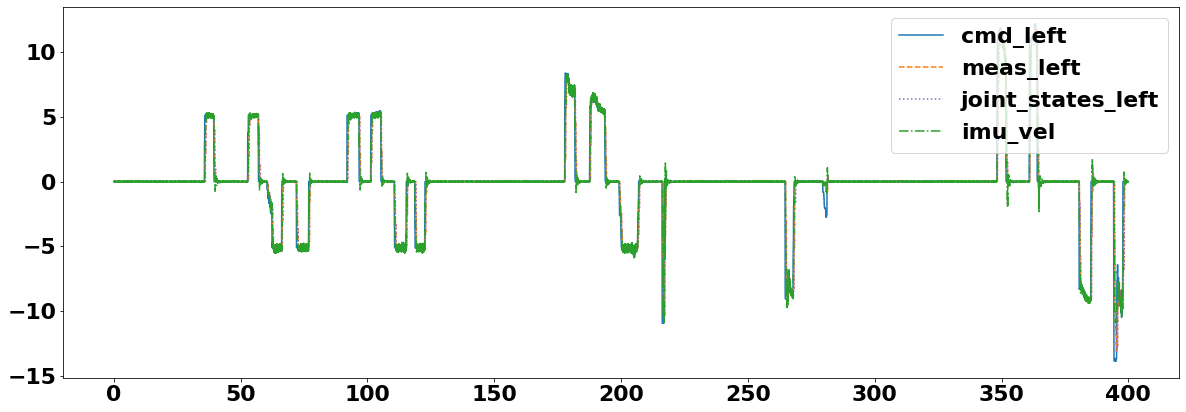

In [111]:
# plot commanded and measured wheel velocities
slice_start = 0
slice_end = 40000

# %matplotlib widget

plt.figure(1, figsize=(20,15))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_left')
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='meas_left')
plt.plot(time_arr[slice_start:slice_end], left_vel_js_arr[slice_start:slice_end], c='tab:purple', linestyle='dotted', label='joint_states_left')
plt.plot(time_arr[slice_start:slice_end], imu_arr[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='imu_vel')
plt.legend()

plt.show()

In [112]:
# Run model on all data

# init tau_c and tau_d values

tau_c = 0.15
tau_d = 0.1

for i in range(10, meas_index_arr.shape[0]-1):
    
    dt = (time_arr[i] - time_arr[i-1])
    if dt < 0.000001:
        left_model_vel[i+1] = left_model_vel[i]
    else:
        left_model_vel[i+1] = powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_model_vel, i, dt)
    


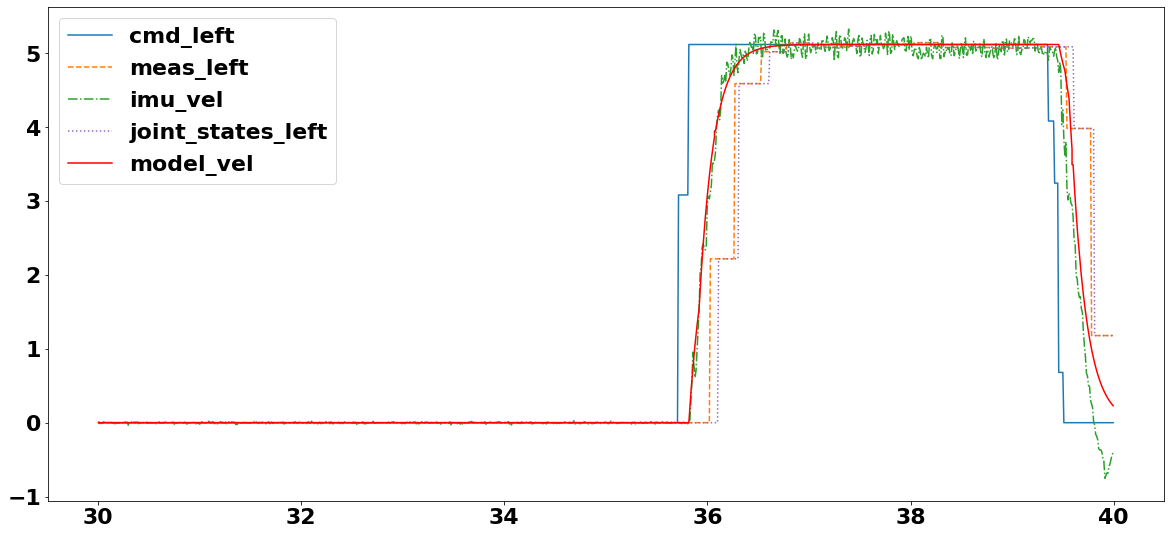

In [113]:
# plot commanded and measured wheel velocities
slice_start = 3000
slice_end = 4000

plt.figure(2, figsize=(20,20))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_left')
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='meas_left')
plt.plot(time_arr[slice_start:slice_end], imu_arr[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='imu_vel')
plt.plot(time_arr[slice_start:slice_end], left_vel_js_arr[slice_start:slice_end], c='tab:purple', linestyle='dotted', label='joint_states_left')
plt.plot(time_arr[slice_start:slice_end], left_model_vel[slice_start:slice_end], c='red', linestyle='solid', label='model_vel')
plt.legend()

plt.show()

In [114]:
# Run EKF for model parameters (imu)

tau_c = 0.100
tau_d = 0.100

left_EKF_mod_vel_imu = np.zeros((meas_index_arr.shape[0]))
left_EKF_vel = np.zeros((meas_index_arr.shape[0]))
#right_model_vel = np.zeros((meas_index_arr.shape[0]))
pred_start = 0

d_tau_c = 0.01
tau_c_add = tau_c + d_tau_c
tau_c_sub = tau_c - d_tau_c

d_tau_d = 0.01
tau_d_add = tau_d + d_tau_d
tau_d_sub = tau_d - d_tau_d

vel_tau_c_add = 0
vel_tau_c_sub = 0

vel_tau_d_add = 0
vel_tau_d_sub = 0

d_left_vel_cmd = 0.01
left_vel_cmd_add_arr = left_vel_cmd_arr + d_left_vel_cmd
left_vel_cmd_sub_arr = left_vel_cmd_arr - d_left_vel_cmd

P = np.array([[0.05, 0.0], [0.0, 0.05]])
trans_mat = np.array([[0.0,0.0], [0.0, 0.0]])
Cv = np.array([[0.005, 0.0], [0.0, 0.005]])

meas_jac = np.array([0.0, 0.0])
Cw = 0.1

tau_arr = np.zeros((imu_arr.shape[0], 2))
tau_arr[0,0] = tau_c
tau_arr[0,1] = tau_d

I_2 = np.eye(2,2)


for i in range(1, time_arr.shape[0]-1): 
    dt = time_arr[i] - time_arr[i-1]
#     print(tau_d)
    
    if dt < 0.000001:
        left_EKF_vel[i+1] = left_EKF_vel[i]
        left_EKF_mod_vel_imu[i+1] = left_EKF_mod_vel_imu[i]
        tau_arr[i, :] = tau_arr[i-1,:]
    
    else:
    
        left_EKF_vel[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, imu_arr, i, dt)

        vel_tau_c_add = powerTrain_vel(tau_c_add, tau_d, left_vel_cmd_arr, imu_arr, i, dt)
        vel_tau_c_sub = powerTrain_vel(tau_c_sub, tau_d, left_vel_cmd_arr, imu_arr, i, dt)

        vel_tau_d_add = powerTrain_vel(tau_c, tau_d_add, left_vel_cmd_arr, imu_arr, i, dt)
        vel_tau_d_sub = powerTrain_vel(tau_c, tau_d_sub, left_vel_cmd_arr, imu_arr, i, dt)

        left_vel_cmd_add = powerTrain_vel(tau_c, tau_d, left_vel_cmd_add_arr, imu_arr, i, dt)
        left_vel_cmd_sub = powerTrain_vel(tau_c, tau_d, left_vel_cmd_sub_arr, imu_arr, i, dt)

        meas_jac[0] = central_diff(vel_tau_c_add, vel_tau_c_sub, d_tau_c)
        meas_jac[1] = central_diff(vel_tau_d_add, vel_tau_d_sub, d_tau_d)
        comm_jac = central_diff(left_vel_cmd_add, left_vel_cmd_sub, d_left_vel_cmd)

        P = trans_mat @ P @ trans_mat.T + comm_jac ** 2 * Cv
        innov = imu_arr[i+1] - left_EKF_vel[i+1]
        K_gain = P @ meas_jac.T * (meas_jac @ P @ meas_jac.T + Cw) ** (-1)
        tau_arr[i, :] = tau_arr[i-1,:] + K_gain * innov

        P = (I_2 - K_gain @ meas_jac) @ P

        tau_c = tau_arr[i,0]
        tau_d = tau_arr[i,1]

        left_EKF_mod_vel_imu[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_EKF_mod_vel_imu, i, dt)

In [115]:
print(tau_arr)
tau_arr_imu = tau_arr

[[0.1        0.1       ]
 [0.1        0.1       ]
 [0.1        0.1       ]
 ...
 [0.16834817 0.08197666]
 [0.16834808 0.08197666]
 [0.         0.        ]]


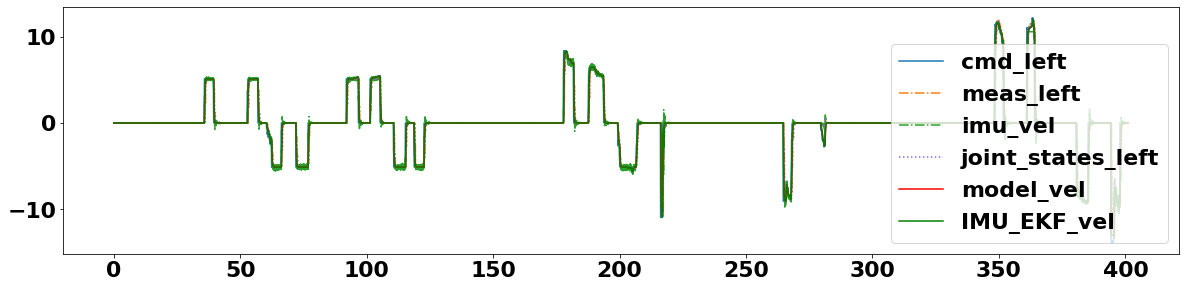

In [105]:
# plot commanded and measured wheel velocities
slice_start = 1
slice_end = time_arr.shape[0]

plt.figure(2, figsize=(20,10))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='cmd_left')
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='-.', label='meas_left')
plt.plot(time_arr[slice_start:slice_end], imu_arr[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='imu_vel')
plt.plot(time_arr[slice_start:slice_end], left_vel_js_arr[slice_start:slice_end], c='tab:purple', linestyle='dotted', label='joint_states_left')
plt.plot(time_arr[slice_start:slice_end], left_model_vel[slice_start:slice_end], c='red', linestyle='solid', label='model_vel')
plt.plot(time_arr[slice_start:slice_end], left_EKF_mod_vel_imu[slice_start:slice_end], c='green', linestyle='solid', label='IMU_EKF_vel')
plt.legend()

plt.show()

In [116]:
# Run EKF for model parameters (encoders)

tau_c = 0.1
tau_d = 0.1

left_EKF_mod_vel = np.zeros((meas_index_arr.shape[0]))
left_EKF_vel = np.zeros((meas_index_arr.shape[0]))
#right_model_vel = np.zeros((meas_index_arr.shape[0]))
pred_start = 0

d_tau_c = 0.01
tau_c_add = tau_c + d_tau_c
tau_c_sub = tau_c - d_tau_c

d_tau_d = 0.01
tau_d_add = tau_d + d_tau_d
tau_d_sub = tau_d - d_tau_d

vel_tau_c_add = 0
vel_tau_c_sub = 0

vel_tau_d_add = 0
vel_tau_d_sub = 0

d_left_vel_cmd = 0.01
left_vel_cmd_add_arr = left_vel_cmd_arr + d_left_vel_cmd
left_vel_cmd_sub_arr = left_vel_cmd_arr - d_left_vel_cmd

P = np.array([[0.05, 0.0], [0.0, 0.05]])
trans_mat = np.array([[0.0,0.0], [0.0, 0.0]])
Cv = np.array([[0.05, 0.0], [0.0, 0.05]])

meas_jac = np.array([0.0, 0.0])
Cw = 10.0

tau_arr = np.zeros((imu_arr.shape[0], 2))
tau_arr[0,0] = tau_c
tau_arr[0,1] = tau_d

I_2 = np.eye(2,2)


for i in range(1, time_arr.shape[0]-1): 
    dt = time_arr[i] - time_arr[i-1]
    
    if dt < 0.000001:
        left_EKF_vel[i+1] = left_EKF_vel[i]
        left_EKF_mod_vel[i+1] = left_EKF_mod_vel[i]
        tau_arr[i, :] = tau_arr[i-1,:]
        
    else:
        left_EKF_vel[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_EKF_vel, i, dt)

        vel_tau_c_add = vel_tau_c_add + powerTrain_vel(tau_c_add, tau_d, left_vel_cmd_arr, left_vel_meas_arr, i, dt)
        vel_tau_c_sub = vel_tau_c_sub +  powerTrain_vel(tau_c_sub, tau_d, left_vel_cmd_arr, left_vel_meas_arr, i, dt)

        vel_tau_d_add = vel_tau_d_add + powerTrain_vel(tau_c, tau_d_add, left_vel_cmd_arr, left_vel_meas_arr, i, dt)
        vel_tau_d_sub = vel_tau_d_sub + powerTrain_vel(tau_c, tau_d_sub, left_vel_cmd_arr, left_vel_meas_arr, i, dt)

        left_vel_cmd_add = left_vel_cmd_add + powerTrain_vel(tau_c, tau_d, left_vel_cmd_add_arr, left_vel_meas_arr, i, dt)
        left_vel_cmd_sub = left_vel_cmd_sub + powerTrain_vel(tau_c, tau_d, left_vel_cmd_sub_arr, left_vel_meas_arr, i, dt)


        if left_vel_meas_arr[i+1] != left_vel_meas_arr[i]:
            meas_jac[0] = central_diff(vel_tau_c_add, vel_tau_c_sub, d_tau_c)
            meas_jac[1] = central_diff(vel_tau_d_add, vel_tau_d_sub, d_tau_d)
            comm_jac = central_diff(left_vel_cmd_add, left_vel_cmd_sub, d_left_vel_cmd)

            P = trans_mat @ P @ trans_mat.T + comm_jac ** 2 * Cv
            innov = left_vel_meas_arr[i+1] - left_EKF_vel[i+1]
            K_gain = P @ meas_jac.T * (meas_jac @ P @ meas_jac.T + Cw) ** (-1)
            tau_arr[i, :] = tau_arr[i-1,:] + K_gain * innov

            P = (I_2 - K_gain @ meas_jac) @ P

            tau_c = tau_arr[i,0]
            tau_d = tau_arr[i,1]

            vel_tau_c_add = 0
            vel_tau_c_sub = 0
            vel_tau_d_add = 0
            vel_tau_d_sub = 0
            left_vel_cmd_add = 0
            left_vel_cmd_sub = 0
            left_EKF_vel[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_EKF_vel, i, dt)

        else:
            tau_arr[i, :] = tau_arr[i-1,:]
    
        left_EKF_mod_vel[i+1] =  powerTrain_vel(tau_c, tau_d, left_vel_cmd_arr, left_EKF_mod_vel, i, dt)

In [117]:
tau_arr_enc = tau_arr

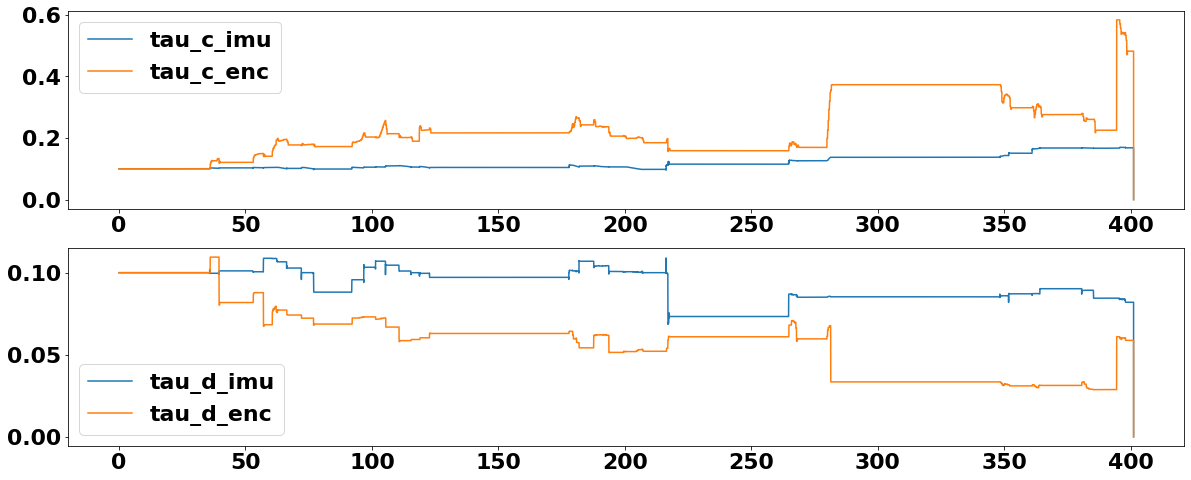

In [118]:
plt.figure(2, figsize=(20,8))
plt.subplot(211)
plt.plot(time_arr, tau_arr_imu[:,0], c='tab:blue', label='tau_c_imu')
plt.plot(time_arr, tau_arr_enc[:,0], c='tab:orange', label='tau_c_enc')
plt.legend()

plt.figure(2, figsize=(20,8))
plt.subplot(212)
plt.plot(time_arr, tau_arr_imu[:,1], c='tab:blue', label='tau_d_imu')
plt.plot(time_arr, tau_arr_enc[:,1], c='tab:orange', label='tau_d_enc')
plt.legend()

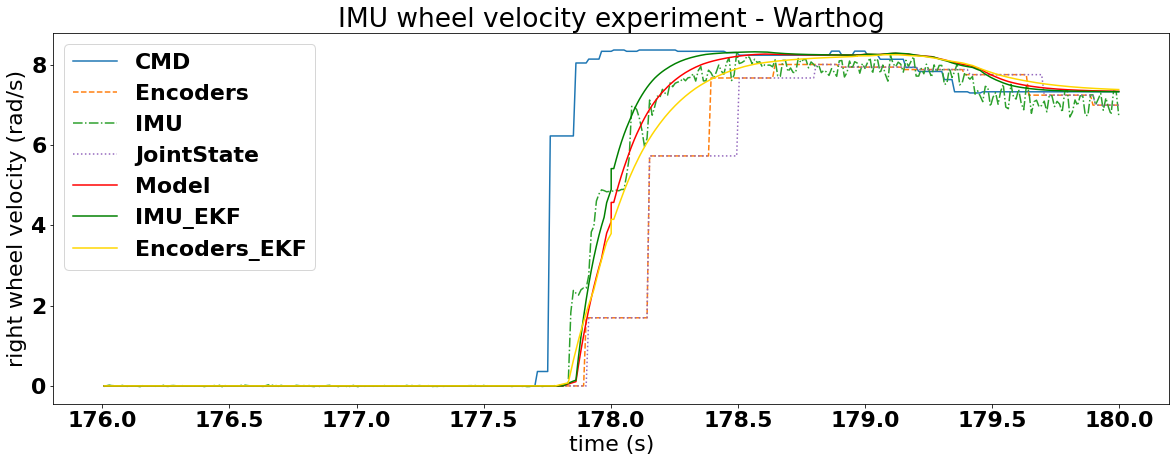

In [122]:
# plot commanded and measured wheel velocities
slice_start = 17600
slice_end = 18000

plt.figure(2, figsize=(20,15))
plt.subplot(211)
plt.plot(time_arr[slice_start:slice_end], left_vel_cmd_arr[slice_start:slice_end], c='tab:blue', label='CMD')
plt.plot(time_arr[slice_start:slice_end], left_vel_meas_arr[slice_start:slice_end], c='tab:orange', linestyle='dashed', label='Encoders')
plt.plot(time_arr[slice_start:slice_end], imu_arr[slice_start:slice_end], c='tab:green', linestyle='dashdot', label='IMU')
plt.plot(time_arr[slice_start:slice_end], left_vel_js_arr[slice_start:slice_end], c='tab:purple', linestyle='dotted', label='JointState')
plt.plot(time_arr[slice_start:slice_end], left_model_vel[slice_start:slice_end], c='red', linestyle='solid', label='Model')
plt.plot(time_arr[slice_start:slice_end], left_EKF_mod_vel_imu[slice_start:slice_end], c='green', linestyle='solid', label='IMU_EKF')
plt.plot(time_arr[slice_start:slice_end], left_EKF_mod_vel[slice_start:slice_end], c='gold', linestyle='solid', label='Encoders_EKF')
plt.xlabel('time (s)')
plt.ylabel('right wheel velocity (rad/s)')
plt.title('IMU wheel velocity experiment - Warthog')
plt.legend()

plt.save

plt.show()